In [18]:
import numpy as np
import numpy.random as rnd
import matplotlib.pyplot as plt
from matplotlib import cm
import MG
import mpl_toolkits.mplot3d.axes3d
from scipy.interpolate import CubicSpline

# Enable interactive plot
%matplotlib inline
#%matplotlib notebook

In [19]:
K=np.array([[7.70886218e+02, 0.00000000e+00, 4.13139293e+02],
   [0.00000000e+00, 7.370886218e+02, 3.11105542e+02],
   [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])
Cx = K[0,2]
Cy = K[1,2]
Fx = K[0,0]
Fy = K[1,1]
F = 0.5*(Fx+Fy)
Rp = 0.06 #El diametro de la pelota
N = 100
N = N + 1

#tiempo entre mediciones (segundos)
dt = 0.1



# Seguimiento 3D

A diferencia del ejemplo lineal, en este caso el objeto a seguir se mueve en 3 dimensiones, y la distancia entre el objeto y la cámara varía, lo que hace que sea un problema no lineal.

El ejemplo se estructura como una pelota que se mueve en frente de una cámara. Conocemos el tamaño de la pelota, la matriz de calibración de la cámara, y existe un procedimiento de detección que encuentra la posición de la pelota en la imagen, extrayendo el centro geométrico de la pelota en la imagen, asi como su radio. 


![Image](images/PelotaVerde.gif)

El vector de mediciones $\mathbf{z}$ se componerá de estas tres mediciones:

$$\begin{aligned}
\mathbf{z} & = \left[ x, y, r, \dot{x}, \dot{y}, \dot{r} \right]^\top 
\end{aligned}$$

donde la dupla $(x,y)$ corresponde a las coordenadas de la pelota de la pelota observada en la imagen, la dupla $(\dot{x}, \dot{y})$ corresponde a la velocidad de translación de la pelota en la imagen, $r$ corresponde a la medición del radio de la pelota en la imagen, y $\dot{r}$  a la razón de cambio del radio de la pelota en la imagen.

El estado $\mathbf{x}$ del sistema estara compuesto por las coordenadas tridimensionales de la pelota con respecto al marco de referencia centrado en la cámara, así como su derivada:

$$
\begin{aligned}
\mathbf{x} & =  \left[ \mathbf{P}, \mathbf{\dot{P}} \right]^\top
\end{aligned}
$$

donde el vector $\mathbf{P}$ representa la posición tridimensional de la pelota en la escena, y $\mathbf{\dot{P}}$ representa su velocidad  translacional. Como el objeto en cuestión es una esfera, no se realiza un seguimiento de movimiento rotacional.

In [20]:
#Genera Datos de Movimiento.
mg = MG.MackeyGlass(10, init=[0.9697, 0.9699, 0.9794, 1.0003, 1.0319, 1.0703, 1.1076, 1.1352, .1485, 1.1482, 1.1383, 1.1234, 1.1072, 1.0928, 1.0820, 1.0756, 1.0739, 1.0759])

#Este iterador itera sobre la serie de tiempo de Mackey-Glass
itMG = iter(mg)

interpFact = 5

Xgt=np.zeros((6, interpFact * (N-1) + 1))

X=np.zeros((1, N))

# Definimos las coordenadas X de la pelota.
for i in range(N):
   X[0, i] = next(itMG)
t = np.linspace(0,len(X[0]),len(X[0]))
t10 = np.linspace(0, len(X[0]), interpFact * (len(X[0])-1)+1)
csX = CubicSpline(t, X[0])
Xgt[0, :] = csX(t10)

# Dejamos pasar 500 iteraciones.
for i in range(500):
   next(itMG)

# Definimos las coordenadas Y de la pelota.
for i in range(N):
   X[0, i] = next(itMG)
csY = CubicSpline(t, X[0])
Xgt[1, :] = csY(t10)

# Dejamos pasar 750 iteraciones.
for i in range(750):
   next(itMG)

# Definimos las coordenadas Y de la pelota.
for i in range(N):
   X[0, i] = next(itMG)
csZ = CubicSpline(t, X[0])
Xgt[2, :] = csZ(t10)
    
[minX, maxX] = [np.min(Xgt[0,:]),np.max(Xgt[0,:])]
[minY, maxY] = [np.min(Xgt[1,:]),np.max(Xgt[1,:])]
[minZ, maxZ] = [np.min(Xgt[2,:]),np.max(Xgt[2,:])]
Xgt[0,:] = (Xgt[0,:]-minX)/(maxX-minX)-0.75
Xgt[1,:] = 1.5*(Xgt[1,:]-minY)/(maxY-minY)-0.5
Xgt[2,:] = 4*(Xgt[2,:]-minZ)/(maxZ-minZ)+1.5

N = len(Xgt[0])

T = np.linspace(0,N,N)*dt



## Construcción del vector de medición.

Para construir el vector de medición, planteamos primero hacer una adecuación de las mediciónes que obtenemos de la cámara para hacerlas independientes de sus parámetros intrínsecos. Pero primero es necesario explicar cual es el modelo de formación de imagenes, que involucra a dichos parámetros intrínsecos. En el resto de esta sección se describirá cual es el modelo de formación de imágenes y el procedimiento de escalación para obtener el vector de medición en cantidades sin dimensiones.

### Modelo de formación de imágenes.

El modelo que describe como se relacióna una coordenada tridimensional $(X, Y, Z)$ con las coordenada en pixeles  $(x_p, y_p)$ en la imagen es el siguiente:

$$
\begin{aligned}
x_p & = & \frac{f_x X} {Z} + Cx\\
y_p & = & \frac{f_y Y} {Z} + Cy\\
\end{aligned}
$$

donde $(f_x, f_y)$ es un factor de escalamiento que combina el tamaño de cada pixel en el sensor y la distancia focal de la cámara y sus unidades son pixeles y $(C_x, C_y)$ corresponde al punto principal de la imagen, _i.e._ la intersección del eje principal de la cámara y el plano de la imagen.

Una pelota de radio $R$ que se proyecta en la imagen produce una imagen de un elipsoide en donde la distancia entre las coordenadas $(x_b, y_b)$ y $(x_p, y_p)$ situadas en el borde y centro de la imagen de la pelota respectivamente es el siguiente:

$$
\begin{aligned}
r_p & = & \sqrt{f_x^2 (x_b-x_p)^2+f_y^2(y_b- y_p)^2} 
\end{aligned}
$$

Si asumimos que $f_x$ y $f_y$ son iguales o muy similares, lo cual suele ser el caso en cámaras modernas donde los pixeles son cuadrados, y asumimos que la distancia del centro de la pelota a cualquier posición en su borde es un constante $R$, podemos simplificar la expresión anterior como sigue:

$$
\begin{aligned}
r_p & = & \frac{f\;R}{Z}
\end{aligned}
$$

donde $f = f_x = f_y$.

### Escalamiento de datos de entrada.

Por simplicidad es conveniente transladar y escalar las coordenadas del centro de la pelota  y escalar el radio de la proyección de la pelota en la imagen, ambos medidos en pixeles,  a cantidades sin dimensiones.

La posición de las coordenada $(x_p, y_p)$ y el radio de la proyección de  la pelota se en la imagen, expresados en cantidades sin dimensiones se describen como sigue:

$$
\begin{aligned}
x & =  \frac{x_p - C_x}{f}\\
y & =  \frac{y_p - C_y}{f}\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,(1)\\
r & =  \frac{r_p}{f}
\end{aligned}
$$

### Construcción del vector de medición.

Como se menciono antes el vector de medición contiene la posición y la velocidad de la pelota en la imagen, así como el radio de imagen proyectada. Mientras que la posición y el radio se obtienen por medio del procedimiento de adecuación descrito arriba, la velocidad se a partir de el computo de la razón de cambio entre imágenes en la secuencia.

El cómputo de la velocidad se estima como la diferencia entre las coordenadas del centro de la pelota en la imágenes $k$ y $k-1$ de la secuencia, dividido entre el tiempo $\Delta t$ transcurrido entre la captura de ambas imágenes:

$$
\begin{aligned}
\dot{x_k} & = & \frac{x_k-x_{k-1}}{\Delta t}\\
\dot{y_k} & = & \frac{y_k-y_{k-1}}{\Delta t}\\
\dot{r_k} & = & \frac{r_k-r_{k-1}}{\Delta t}
\end{aligned}
$$

En el caso del cómputo de las velocidades en el primer cuadro, para el que no existe una imagen previa,  existen dos alternativas que se pueden considerar. La primera es  asumir que en la primera imagen las velocidades son iguales a cero, o la segunda que consiste en ignorar la primera imagen de la secuencia, y empezar el proceso a partir de la segunda imagen.

En general este proceso suele ser mas elaborado, pues el proceso de inicialización puede considerar procesar mas de una imagen para encontrar los valores iniciales.

In [21]:
#Proyectamos y normalizamos coordenadas 3D al plano de la imagen.
p = np.dot(K,Xgt[0:3,:])
r = np.zeros((1,N))
for i in range(len(p[0])):
    p[:,i] = p[:, i]/p[2,i]
    r[0,i] = F * Rp / Xgt[2,i]
dp = np.diff(p[0:2,:])
dr = np.diff(r)
pxMin = np.min(p[0,:])
pxMax = np.max(p[0,:])
pyMin = np.min(p[1,:])
pyMax = np.max(p[1,:])

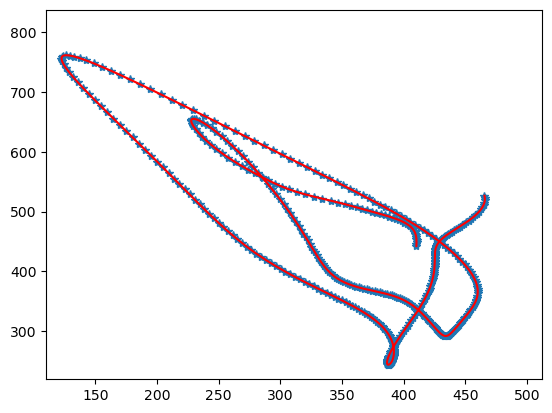

In [35]:
fig1=plt.figure()

ax1 = fig1.add_subplot(111, autoscale_on=False, xlim=((1-0.1)*pxMin,(1+0.1)*pxMax), ylim=((1-0.1)*pyMin,(1+0.1)*pyMax))
plt.plot(p[0,:],p[1,:],'*',p[0,:],p[1,:],'r')

In [23]:
#Llenamos el vector de medicion.
z =np.zeros((6,N))
z[0:3,0]=[p[0,0],p[1,0],r[0,0]]
z[:,1:N]=np.vstack([p[0,1:N],p[1,1:N],r[0,1:N], dp[0,:]/dt, dp[1,:]/dt, dr[0,:]/dt])

In [24]:
#definimos en ruido de medicion.
varPosX = 1.
varPosY = 1.
varR = 1. * 10e-2
varVelX = 1.5 * 10e-4
varVelY = 1.5 * 10e-5
varVelR = 1.5 * 10e-6

factNR = 1.

noiseX = rnd.normal(0,np.sqrt(varPosX),(1,N))
noiseY = rnd.normal(0,np.sqrt(varPosY),(1,N))
noiseR = rnd.normal(0,np.sqrt(varR),(1,N))
noiseVX = rnd.normal(0,np.sqrt(varVelX),(1,N))
noiseVY = rnd.normal(0,np.sqrt(varVelY),(1,N))
noiseVR = rnd.normal(0,np.sqrt(varVelR),(1,N))

#Vectores de Medicion (proyeccion de posicion + ruido).
#Esta es la entrada de datos para el filtro de Kalman.
zn = z + factNR * np.vstack([noiseX, noiseY, noiseR, noiseVX, noiseVY, noiseVR])



In [25]:
#Estimamos el ruido de la medicion y lo 'canonizo'.
R =  np.cov(factNR * np.vstack([noiseX/Fx, noiseY/Fy, noiseR/F, noiseVX/Fx, noiseVY/Fy, noiseVR/F]))

#Definimos el ruido del proceso
Q = np.cov(rnd.rand(6,N))*np.diag([0.04, 0.04, 0.04, 0.2, 0.2, 0.2])/200

In [26]:
# Terminamos de definimos el Estado (ground truth)
Xgt[3:6, 0:N-1] = np.vstack([np.diff(Xgt[0,:]), np.diff(Xgt[1,:]), np.diff(Xgt[2,:])]) / dt;
Xgt[3:6, N-1] = Xgt[3:6, N-2];

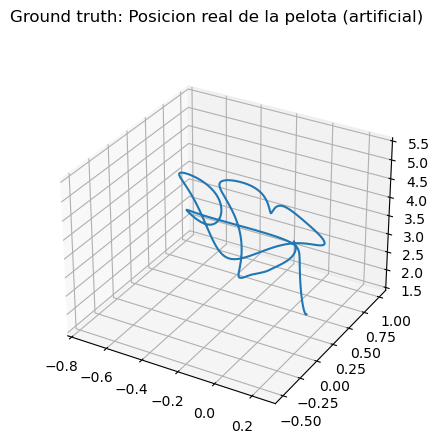

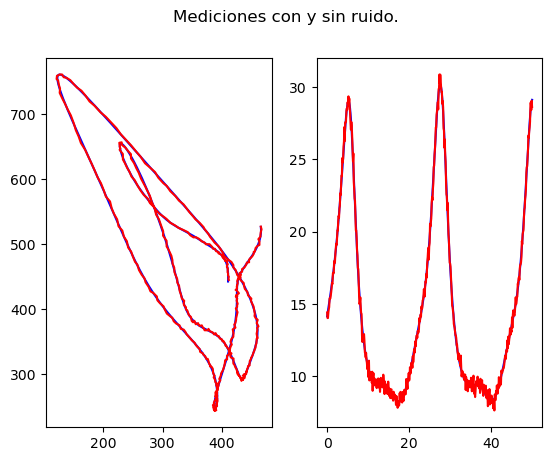

In [27]:
fig1=plt.figure()
fig1.suptitle("Ground truth: Posicion real de la pelota (artificial)")
ax1 = fig1.add_subplot(111, projection='3d')
ax1.plot(Xgt[0,:], Xgt[1,:], Xgt[2,:])

fig2, (ax21, ax22) = plt.subplots(1,2)
fig2.suptitle("Mediciones con y sin ruido.")
ax21.plot(z[0,:],z[1,:],'b', zn[0,:],zn[1,:],'r')
ax22.plot(T,z[2,:],'b', T,zn[2,:],'r')


# Matriz de Transición de estado

La función $\mathbf{A}$ que mapea un estado actual dado un estado previo se describe como sigue:

$$
\begin{aligned}
\mathbf{x_t} & =  \mathbf{Ax_{t-1}}
\end{aligned}
$$

donde $\mathbf{A}$ se define como sigue:

$$
\begin{aligned}
\mathbf{A} & =  \left[\begin{array}{cccccc}
1 & 0 & 0 &\Delta t & 0 & 0\\
0 & 1 & 0 & 0 & \Delta t & 0\\
0 & 0 & 1 & 0 & 0 & \Delta t\\
0 & 0 & 0 & 1 & 0 & 0\\
0 & 0 & 0 & 0 & 1 & 0\\
0 & 0 & 0 & 0 & 0 & 1\\
\end{array}\right]
\end{aligned}
$$



In [28]:
A = np.eye(6)
A[0,3] = dt
A[1,4] = dt
A[2,5] = dt

## Etapa de actualización.

En la etapa de actualización es necesario contar con un función $\mathbf{z}=h(\mathbf{x})$ que mapeé el vector de estado $\mathbf{x}$ en el vector de mediciones $\mathbf{z}$.  En este caso definimos dicha función como sigue:

$$
h(\mathbf{x}) = \left[\begin{array}{ccccc}
\frac{X}{Z} & \frac{Y}{Z} & \frac{R}{Z} & \frac{-\dot{X}+x\dot{Z}}{Z} & \frac{-\dot{Y}+y\dot{Z}}{Z} & -\frac{R\dot{Z}}{Z}\\ \end{array}\right]^\top
$$

donde $X, Y$ y $Z$ son los miembros del vector de posición $\mathbf{P}$, $\dot{X},\dot{Y}$ y $\dot{Z}$ son los miembros del vector de velocidad $\mathbf{\dot{P}}$, $R$ es el radio de la pelota expresado en metros.  $x$ y $y$ se definieron en las equaciones (1) arriba. 

### Como se calcularon los terminos de velocidad en la imagen a partir de la velocidad en el espacio.

Los terminos de velocidad en la imagen se obtuviero en el trabajo seminal de Longuet-Higgins, y la forma completa es como sigue:

*The projection into the image plane  of a space point $\mathbf{P}=[X, Y, Z]^\top$  moving with a  translational  velocity $\mathbf{T}=[T_x,  T_y, T_z]^\top$ and an angular velocity $\mathbf{\Omega}=[\Omega_x, \Omega_y, \Omega_z]^\top$, defined with respect  to  the camera axis frame,  is given by (Longuet-Higgins&Prazdny1980):*

$$
\begin{aligned} \left[ 
 \begin{array}{c} u \\ v \end{array} \right] = \frac{1}{Z} \left[
 \begin{array}{ccc} -1 & 0 & x \\ 0 & -1 & y \end{array} \right]
 \left[ \begin{array}{c} T_x\\ T_y\\ T_z \end{array} \right] + \left[ 
 \begin{array}{ccc} xy & -(1+x^2) & y\\
 (1+y^2) & -xy & -x \end{array} \right] \left[ 
 \begin{array}{c} \Omega_x\\ \Omega_y\\ \Omega_z \end{array} \right]
 \end{aligned}
$$

 *where $[u,v]^\top$ is the optical flow vector. This  equation also expresses  the case when the point  $P$  is  static and  the  camera  is moved  with translational velocity $-\mathbf{T}$ and  angular velocity $-\mathbf{\Omega}$* (_i.e._ *it is the relative  motion of observer  and object that induces the optical flow*).
 
 $(x,y)$ se definieron arriba, cuando se presentó el modelo de formación de imágenes.
 
La relacion entre $(\dot{x}, \dot{v})$ y $(u,v)$ es la siguente: 
$$
\begin{aligned}
u & = \dot{x}\\
v & = \dot{y}\\
\end{aligned}
$$

# Definición de matriz de uso general.

Abajo definimos las diferentes matrices que se usan para almacenar los diferentes variables del sistema y para almacenar resultados.

In [29]:
x = Xgt[:,0]

xp = np.zeros((6, 1))

zk = np.zeros((6, 1))

Hk = np.zeros((6,6))

Kg = np.zeros((6,6))

#Definimos el Ruido del estado
Pk = 10 * np.eye(6)

#Ruido del estado predicho.
Pkp = np.zeros((6,6))

XE = np.zeros((6,N+1))
ZKS = np.zeros((6,N+1))
ZK = np.zeros((6, 1))

k = 0

# Ciclo principal del algoritmo

En el siguiente bloque se muestra el ciclo principal del algoritmo.

![Image](images/FiltroKalmanExtendido.png)

La única diferencia es que en este caso la etapa de predicción es lineal, por lo que seguimos utilizando la ecuación que corresponde al filtro de Kalman convencional.

Notese que la matriz $\mathbf{H}$ tiene que calcularse de nueva en cada iteración del filtro.

La matriz $\mathbf{H}$ se calcula como el Jacobiano de la función $h$ y queda definida como sigue:

$$
\begin{aligned}
\mathbf{H} &=
\left[\begin{array}{cccccc}\frac{1}{Z} & 0 & -\frac{X}{{{Z}^{2}}} & 0 & 0 & 0\\
0 & \frac{1}{Z} & -\frac{Y}{{{Z}^{2}}} & 0 & 0 & 0\\
0 & 0 & -\frac{R}{{{Z}^{2}}} & 0 & 0 & 0\\
-\frac{\dot{Z}}{{{Z}^{2}}} & 0 & \frac{X \dot{Z}}{{{Z}^{3}}}-\frac{\dot{X}-\frac{X\dot{Z} }{Z}}{{{Z}^{2}}} & \frac{1}{Z} & 0 & -\frac{X}{{{Z}^{2}}}\\
0 & -\frac{\dot{Z}}{{{Z}^{2}}} & \frac{Y\dot{Z}}{{{Z}^{3}}}-\frac{\dot{Y}-\frac{Y\dot{Z}}{Z}}{{{Z}^{2}}} & 0 & \frac{1}{Z} & -\frac{Y}{{{Z}^{2}}}\\
0 & 0 & \frac{R\dot{Z}}{{{Z}^{2}}} & 0 & 0 & -\frac{R}{Z}\end{array}\right]
\end{aligned}
$$

In [30]:
while k < N:
    #Predicción
    xp = np.dot(A,x)
    Pkp = np.dot(A , np.dot(Pk, A.transpose())) + Q
   
    
    #Obtenemos una medición
    zk = zn[:,k]
    
    if k == 0:
        zk[3:] = 0
        
    #Lo convertimos en coordenadas canonicas.
    zk[0] = (zk[0] - Cx) / Fx
    zk[1] = (zk[1] - Cy) / Fy
    zk[2] = zk[2] / F
    zk[3] = zk[3] / Fx
    zk[4] = zk[4] / Fy
    zk[5] = zk[5] / F
    
    # Aqui evaluamos la funcion h(x)m que es no lineal.
    ZK = np.array([xp[0]/xp[2], xp[1]/xp[2], Rp/xp[2], -(-xp[3]+(xp[0]/xp[2])*xp[5])/xp[2],-(-xp[4]+(xp[1]/xp[2])*xp[5])/xp[2], -Rp*xp[5]/(xp[2]*xp[2])])
    ZKS[:,k] = ZK
    
    X = xp[0]
    Y = xp[1]
    Z = xp[2]
    dX = xp[3]
    dY = xp[4]
    dZ = xp[5]
    Z2 = Z * Z
    Z3 = Z2 * Z
    
    Hk = np.array(\
     [[1/Z,      0,      -X/Z2,                   0,   0,    0],\
      [0,      1/Z,      -Y/Z2,                   0,   0,    0],\
      [0,       0,      -Rp/Z2,                   0,   0,    0],\
      [-dZ/Z2,  0,   (X*dZ)/Z3-(dX-(X*dZ)/Z)/Z2, 1/Z,  0,  -X/Z2],\
      [0,    -dZ/Z2, (Y*dZ)/Z3-(dY-(Y*dZ)/Z)/Z2,  0,  1/Z, -Y/Z2],\
      [0,       0,  2*Rp*dZ/Z3 ,                  0,   0,  -Rp/Z2]])
    
    #Calculamos la ganancia de Kalman
    Kg = np.dot(Pkp, np.dot(Hk.transpose(), np.linalg.inv(np.dot(Hk, np.dot(Pkp, Hk.transpose())) + R)));
    
    #Update
    xek = xp + np.dot(Kg, (zk - ZK))
    Pk = np.dot(np.eye(6)-np.dot(Kg, Hk), Pkp)
    
    XE[:,k] = xek
    x = xek
    k = k + 1

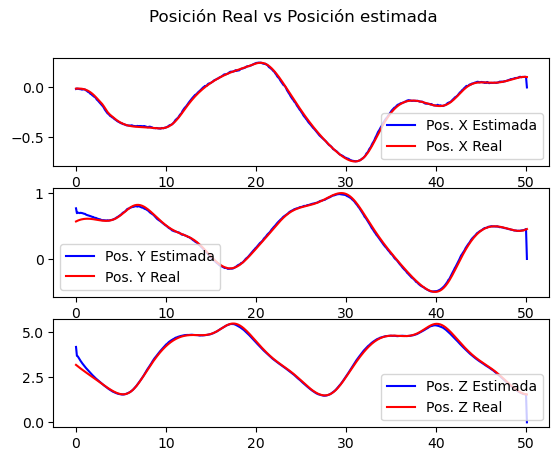

In [31]:

fig3, (ax30, ax31, ax32) = plt.subplots(3,1)
fig3.suptitle("Posición Real vs Posición estimada")
ax30.plot(T, XE[0,1:], 'b', label='Pos. X Estimada')
ax30.plot(T, Xgt[0,:],'r', label='Pos. X Real')
ax31.plot(T, XE[1,1:],'b', label='Pos. Y Estimada')
ax31.plot(T, Xgt[1,:],'r', label='Pos. Y Real')
ax32.plot(T, XE[2,1:],'b', label='Pos. Z Estimada')
ax32.plot(T, Xgt[2,:],'r', label='Pos. Z Real')
ax30.legend()
ax31.legend()
ax32.legend()



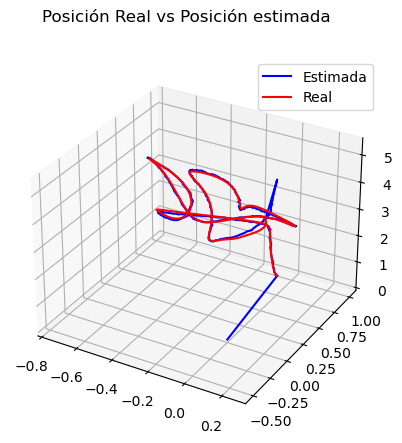

In [32]:
fig4=plt.figure()
fig4.suptitle("Posición Real vs Posición estimada")
ax40 = fig4.add_subplot(111, projection='3d')
ax40.plot(XE[0,:], XE[1,:], XE[2,:], 'b', label='Estimada')
ax40.plot(Xgt[0,:], Xgt[1,:], Xgt[2,:],'r', label='Real')
ax40.legend()

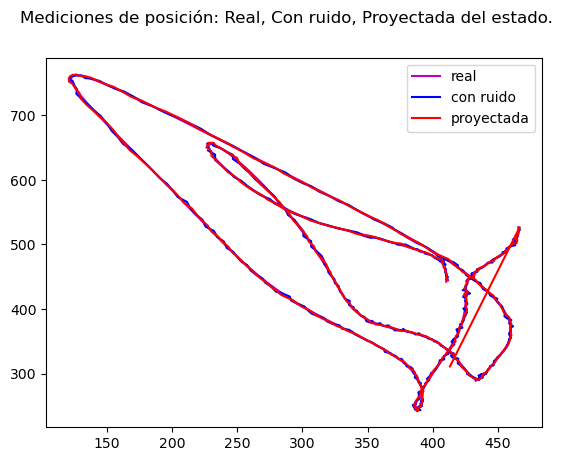

In [33]:
fig5=plt.figure()
fig5.suptitle("Mediciones de posición: Real, Con ruido, Proyectada del estado.")
ax50 = fig5.add_subplot(111)
ax50.plot(z[0,:], z[1,:], 'm', label='real')
ax50.plot(zn[0,:-1]*Fx+Cx, zn[1,:-1]*Fy+Cy, 'b', label='con ruido')
ax50.plot(ZKS[0,:]*Fx+Cx, ZKS[1,:]*Fy+Cy, 'r', label='proyectada')
ax50.legend()

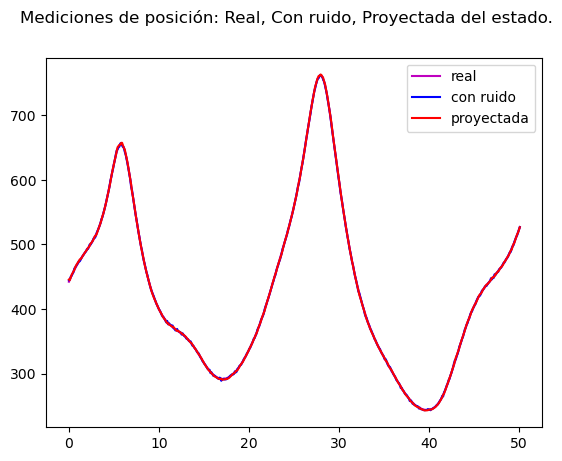

In [34]:
fig6=plt.figure()
fig6.suptitle("Mediciones de posición: Real, Con ruido, Proyectada del estado.")
ax60 = fig6.add_subplot(111)
ax60.plot(T, z[1,:], 'm', label='real')
ax60.plot(T, zn[1,:]*Fy+Cy, 'b', label='con ruido')
ax60.plot(T, ZKS[1,:-1]*Fy+Cy, 'r', label='proyectada')
ax60.legend()